# Olympics Analysis 1896 to 2016, A deep Dive

### By Obira Daniel,

### Data from SportsStats
#### Learn SQL Basics for Data Science Specialization Capstone, Cousera, UC Davis

# 1.0 Data Description, Importing and Checking the Data

 ***I created a parquet file from the csv file, reduced the file from ~40MB to ~5.6MB, it downloads and loads faster using pyarrow***<br>
 
 *Data is read from the web and loaded in to a sqlite database then all analysis stems from SQL queries*<br>
 ***sqlite3***, ***ipython-sql*** *and* ***pyarrow*** *are required for SQL and parquet interfacing accordingly*

## 1.1 Data Description
***
The file athlete_events.csv or olympics.parquet, contains 271,116 rows and 15 columns.<br>
Each row/record corresponds to an individual athlete competing in an individual Olympic event (athlete-events).<br>
The columns are the following:
***
*ID - Unique ID for each individual athlete e.g 55881 for Michael Jordan, 13029 for Usain Bolt;<br>*
*Name - Athlete's Full name;<br>*
Sex - M or F;<br>
Age - 64 bit Float of Age in Years;<br>
Height - 64 bit Float of height In centimeters;<br>
Weight - 64 bit Float of Mass In kilograms;<br>
Team - Team name;<br>
NOC - National Olympic Committee 3-letter code;<br>
Games - Year and season;<br>
Year - Integer of Year of Event;<br>
Season - Summer or Winter;<br>
City - Host city;<br>
Sport - Sport;<br>
Event - Event;<br>
Medal - Gold, Silver, Bronze, or NA.<br>

### 1.2 Data Import, Quick Exploration and Quality Checks

#### 1.21 Data Import/Loading

In [71]:
import os, datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns
import pyarrow
import sqlite3

startTime = datetime.datetime.now()
#file='athlete_events.csv'
#Printing Styling
class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'
    BOLD = '\033[1m'

#csvfile='https://raw.githubusercontent.com/obiradaniel/od_olympics/main/athlete_events.csv'

parquetfile='https://raw.githubusercontent.com/obiradaniel/od_olympics/main/olympics.parquet'

worldcountries = 'https://raw.githubusercontent.com/obiradaniel/od_olympics/main/world_countries.csv'

nocfile = "https://raw.githubusercontent.com/obiradaniel/od_olympics/main/noc_regions.csv"

olympics = pd.read_parquet(parquetfile, engine="pyarrow")
noc = pd.read_csv(nocfile)
countries = pd.read_csv(worldcountries)

olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None


***Checking NOC Data and adding missing NOCS***

In [72]:
#noc_add = pd.DataFrame([['SGP', 'Singapore', None], ['ROT', 'Refugee Olympic Team', None], ['TUV', 'Tuvalu', None], ['UNK', 'Unknown', None], ['EOR', 'Refugee Olympic Team', None]], columns=['NOC', 'region', 'notes'])
#noc_add = pd.DataFrame([['SGP', 'Singapore', None], ['EOR', 'Refugee Olympic Team', None]], columns=['NOC', 'region', 'notes'])

In [73]:
#noc=noc.append(noc_add, ignore_index=True)
#noc= pd.concat([noc, noc_add])

In [74]:
#noc.tail()

,NOC,region,notes
0,SGP,Singapore,None
1,ROT,Refugee Olympic Team,None
2,TUV,Tuvalu,None
3,UNK,Unknown,None
4,EOR,Refugee Olympic Team,None


In [75]:
noc.describe(include='all')

,NOC,region,notes
count,235,232,21
unique,232,209,21
top,ROT,Germany,Netherlands Antilles
freq,2,4,1


*They are 230 Unique NOCS and 206 uniqure reions or countries,<br>
this data will be joined to the main olympic dataset after some basic cleaning*

***Olympic Data Schema***

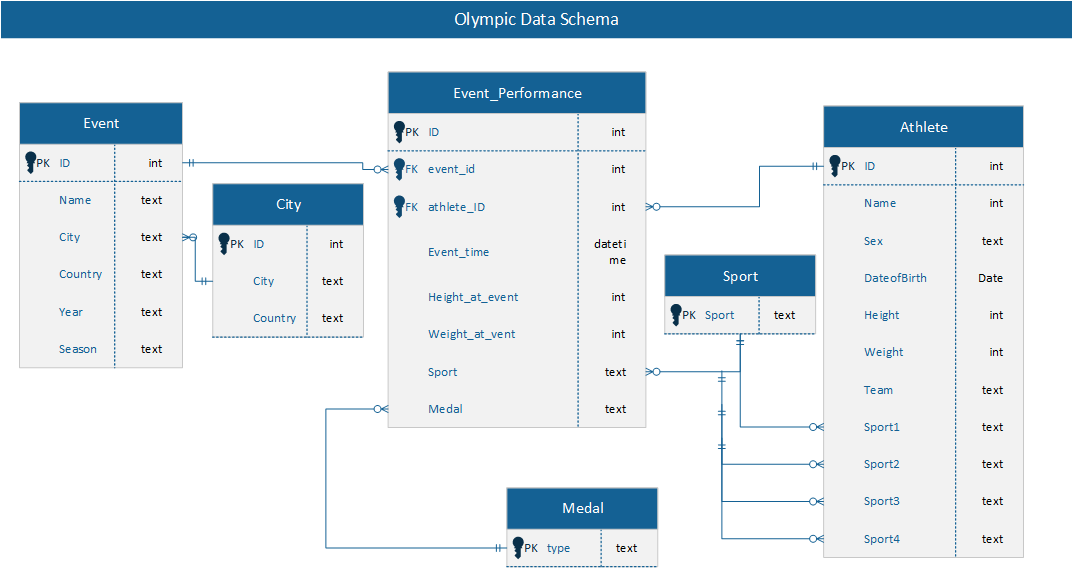

## 1.3 Checking the data for consistency and errors

In [76]:
records = olympics.shape[0]
columns = olympics.shape[1]

print("\nThe data has", records, "records and ", columns, "columns.\n")
print("Data Information Summary")
print(olympics.info())


The data has 271116 records and  15 columns.

Data Information Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB
None


In [77]:
print("Null Value Summary")
olympics.isnull().sum(axis = 0)

Null Value Summary


ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [78]:
print("Range of years is from", min(olympics.Year), "to ", max(olympics.Year))

Range of years is from 1896 to  2016


### 1.3.1 Data Description before Cleaning

In [79]:
print("Data Description for all Variables before cleaning")
olympics.describe(include='all')

Data Description for all Variables before cleaning


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
count,271116.000000,271116,271116,261642.000000,210945.000000,208241.000000,271116,271116,271116,271116.000000,271116,271116,271116,271116,39783
unique,NaN,134732,2,NaN,NaN,NaN,1184,230,51,NaN,2,42,66,765,3
top,NaN,Robert Tait McKenzie,M,NaN,NaN,NaN,United States,USA,2000 Summer,NaN,Summer,London,Athletics,Football Men's Football,Gold
freq,NaN,58,196594,NaN,NaN,NaN,17847,18853,13821,NaN,222552,22426,38624,5733,13372
mean,68248.954396,NaN,NaN,25.556898,175.338970,70.702393,NaN,NaN,NaN,1978.378480,NaN,NaN,NaN,NaN,NaN
std,39022.286345,NaN,NaN,6.393561,10.518462,14.348020,NaN,NaN,NaN,29.877632,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,10.000000,127.000000,25.000000,NaN,NaN,NaN,1896.000000,NaN,NaN,NaN,NaN,NaN
25%,34643.000000,NaN,NaN,21.000000,168.000000,60.000000,NaN,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN
50%,68205.000000,NaN,NaN,24.000000,175.000000,70.000000,NaN,NaN,NaN,1988.000000,NaN,NaN,NaN,NaN,NaN
75%,102097.250000,NaN,NaN,28.000000,183.000000,79.000000,NaN,NaN,NaN,2002.000000,NaN,NaN,NaN,NaN,NaN


***Observations***<br>
1. Numeric Variables
    1. ID seems to show 135,571 unique athletes have ever attended the Olympics
    2. Age has extreme value of 97 years and so does weight with 214 Kg, this will have to be explored
    3. The rest seem fine
2. Text Variables
    1. Names shows 134732 unique values
    2. City, 42 Different Cities, a map will show them well
    3. Rest seem fine

***Checking for Usain Bolt in that data***

In [80]:
olympics.loc[olympics['Name'].str.contains('usain', case=False)].head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
3344,1883,Mamdooh Husain Isa Al-Doseri,M,20.0,NaN,NaN,Bahrain,BRN,1992 Summer,1992,Summer,Barcelona,Cycling,Cycling Men's 100 kilometres Team Time Trial,None
3595,2061,Husain Al-Mutairi,M,18.0,170.0,52.0,Kuwait,KUW,1988 Summer,1988,Summer,Seoul,Boxing,Boxing Men's Flyweight,None
24876,13029,Usain St. Leo Bolt,M,17.0,196.0,95.0,Jamaica,JAM,2004 Summer,2004,Summer,Athina,Athletics,Athletics Men's 200 metres,None
24877,13029,Usain St. Leo Bolt,M,21.0,196.0,95.0,Jamaica,JAM,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Men's 100 metres,Gold
24878,13029,Usain St. Leo Bolt,M,21.0,196.0,95.0,Jamaica,JAM,2008 Summer,2008,Summer,Beijing,Athletics,Athletics Men's 200 metres,Gold


### 1.3.2 Data Checks

***Test 1: Checking for Double Spaces in Athlete Names, should give blank Values***

In [81]:
olympics.loc[olympics['Name'].str.contains('  ', case=False)]['Name'].value_counts()#Name Variable

Jean Honor  Gounot                         17
Paolo Francesco "Paul"  Radmilovic         13
Florence  Andre Isabelle Baverel-Robert    12
Mladenka  Malenia (-Vidovic)                6
Isabella Minna Veronica  Wagner             5
                                           ..
Ana Cludia  da Costa Gonalves               1
Virginia Anne  "Ginny" Gilder               1
Petru Ionel  Gavril                         1
Jorge Ignacio  Garbey Castillo              1
Edmund Roman  Zieliski                      1
Name: Name, Length: 128, dtype: int64

***128 Athletes Names have double spaces***

In [82]:
olympics.loc[olympics['Team'].str.contains('  ', case=False)]['Team'].value_counts()#Team Variable

Series([], Name: Team, dtype: int64)

In [83]:
olympics.loc[olympics['Sport'].str.contains('  ', case=False)]['Sport'].value_counts()#Sport Variable

Series([], Name: Sport, dtype: int64)

In [84]:
olympics.loc[olympics['Event'].str.contains('  ', case=False)]['Event'].value_counts()#Event Variable

Series([], Name: Event, dtype: int64)

In [85]:
olympics.loc[olympics['City'].str.contains('  ', case=False)]['City'].value_counts()#Event Variable

Series([], Name: City, dtype: int64)

***Test 2: Checking for Consinstent Single Spaces and Uniform Cases, should give consitent output,
should easily show inconsitency***

In [86]:
olympics.loc[olympics['Name'].str.contains(' ', case=False)]['Name'].value_counts()#Name Variable

Robert Tait McKenzie           58
Heikki Ilmari Savolainen       39
Joseph "Josy" Stoffel          38
Ioannis Theofilakis            36
Takashi Ono                    33
                               ..
Meng Fanlong                    1
Jennifer Susan "Jenny" Duck     1
Peter Ducke                     1
Marcela Menezes                 1
A Dijiang                       1
Name: Name, Length: 134448, dtype: int64

In [87]:
olympics.loc[olympics['Team'].str.contains(' ', case=False)]['Team'].value_counts()#Team Variable

United States       17847
Great Britain       11404
Soviet Union         5535
South Korea          4344
West Germany         3199
                    ...  
Quando Quando           1
Whitini Star            1
Pop Art                 1
Pierre et Jean-3        1
Dow Jones               1
Name: Team, Length: 435, dtype: int64

In [88]:
olympics.loc[olympics['Sport'].str.contains(' ', case=False)]['Sport'].value_counts()#Sport Variable

Cross Country Skiing         9133
Alpine Skiing                8829
Speed Skating                5613
Ice Hockey                   5516
Water Polo                   3846
Art Competitions             3578
Ski Jumping                  2401
Figure Skating               2298
Table Tennis                 1955
Modern Pentathlon            1677
Short Track Speed Skating    1534
Nordic Combined              1344
Freestyle Skiing              937
Synchronized Swimming         909
Rhythmic Gymnastics           658
Beach Volleyball              564
Rugby Sevens                  299
Military Ski Patrol            24
Jeu De Paume                   11
Basque Pelota                   2
Name: Sport, dtype: int64

In [89]:
olympics.loc[olympics['Event'].str.contains(' ', case=False)]['Event'].value_counts()#Event Variable

Football Men's Football                                5733
Ice Hockey Men's Ice Hockey                            4762
Hockey Men's Hockey                                    3958
Water Polo Men's Water Polo                            3358
Basketball Men's Basketball                            3280
                                                       ... 
Croquet Mixed Doubles                                     2
Archery Men's Target Archery, 50 metres, Individual       2
Archery Men's Target Archery, 33 metres, Individual       2
Archery Men's Target Archery, 28 metres, Individual       2
Aeronautics Mixed Aeronautics                             1
Name: Event, Length: 765, dtype: int64

In [90]:
olympics.loc[olympics['City'].str.contains(' ', case=False)]['City'].value_counts()#Event Variable

Rio de Janeiro       13688
Los Angeles          12423
Mexico City           8588
Salt Lake City        4109
Lake Placid           2098
Sankt Moritz          1657
Cortina d'Ampezzo     1307
St. Louis             1301
Squaw Valley          1116
Name: City, dtype: int64

***By and Large, the case seems to be consitent***

In [91]:
#olympics.loc[olympics['Name'].str.contains('usain', case=False)]
#olympics.loc[olympics['Team'].str.contains(' ', case=False)]

### 1.3.4 Data Cleanup Summary
***
The file athlete_events.csv or olympics.parquet, contains 271,116 rows and 15 columns.<br>
Each row/record corresponds to an individual athlete competing in an individual Olympic event (athlete-events).<br>
The columns are the following:
***
ID - Unique ID, assumed to be clean, no Nulls ***will check would be to see if the same athlete from one NOC has 2 Ids***<br>
Name - Athlete's Full name,134732, unique values ***will be trimmed and double spaces replace with single space***<br>
Sex - M or F; Clean<br>
Age - Integer of years, 9,474 Nulls, ***nothing can be done here, may be check if some athletes declared age in later years then backfill***<br>
Height - In centimeters, okay, 60,171 Nulls<br>
Weight - In kilograms, okay, 62,875 Nulls<br>
Team - Team name, will pick the Country name from the NOC file;***checked, clean***<br>
NOC - National Olympic Committee 3-letter code;<br>
Games - Year and season;<br>
Year - Integer;<br>
Season - Summer or Winter;<br>
City - Host city, ***checked, clean***<br>
Sport - Sport;***checked, clean***<br>
Event - Event;***checked, clean***<br>
Medal - Gold, Silver, Bronze, or NA.<br>

Will add EventScore, Gold ->10, Silver ->7.5, Bronze->5, or NA->1 for qualifying.<br>
Will add medal binary, Gold ->1, Silver ->1, Bronze->1, or NA-0 <br>

Data will be joined to NOC to get Country

***Performing the cleanups***

In [92]:
olympics['Name'] = olympics['Name'].str.replace('  ', ' ')#Replace double space with single space, may have to be run several times
olympics['Name'] = olympics.Name.str.strip()

***Checking the cleaned columns***

In [93]:
olympics.loc[olympics['Name'].str.contains('  ', case=False)]['Name'].value_counts()#Name Variable

Series([], Name: Name, dtype: int64)

In [94]:
olympics.loc[olympics['Name'].str.contains(' ', case=False)]['Name'].value_counts()#Name Variable

Robert Tait McKenzie          58
Heikki Ilmari Savolainen      39
Joseph "Josy" Stoffel         38
Ioannis Theofilakis           36
Takashi Ono                   33
                              ..
Maria Ulrika Kalte             1
Josef Kalt (-Arnet)            1
Katri Johanna Kalpala          1
Dorothea "Dora" Kalpakidou     1
Georges Marcel Lecointe        1
Name: Name, Length: 134447, dtype: int64

### 1.3.5 Data Description After Cleaning

### Joinining the Cleaned Data to NOC

In [95]:
olympics_merge = pd.merge(olympics, noc, on='NOC', how='left')

In [96]:
olympics_merge[olympics_merge["region"].isnull()]['NOC'].value_counts()

ROT    12
TUV     7
UNK     2
Name: NOC, dtype: int64

In [97]:
#olympics[olympics["region"].isnull()]['region'] =olympics[olympics["region"].isnull()]['notes']

#olympics.loc[olympics["region"].isnull(), ['region']]=olympics.loc[olympics["region"].isnull(), ['notes']]

#df['First Season'] = np.where(df['First Season'] > 1990, 1, df['First Season'])
olympics_merge["region"]=np.where(olympics_merge["region"].isnull(), olympics_merge["notes"],olympics_merge["region"])


In [98]:
olympics_merge[olympics_merge["region"].isnull()]['NOC'].value_counts()

Series([], Name: NOC, dtype: int64)

In [99]:
print("Data Description for all Variables After cleaning")
olympics_merge.describe(include='all')

Data Description for all Variables After cleaning


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
count,271137.000000,271137,271137,261661.000000,210961.000000,208259.000000,271137,271137,271137,271137.000000,271137,271137,271137,271137,39783,271137,5039
unique,NaN,134731,2,NaN,NaN,NaN,1184,230,51,NaN,2,42,66,765,3,209,21
top,NaN,Robert Tait McKenzie,M,NaN,NaN,NaN,United States,USA,2000 Summer,NaN,Summer,London,Athletics,Football Men's Football,Gold,USA,Yugoslavia
freq,NaN,58,196608,NaN,NaN,NaN,17847,18853,13821,NaN,222573,22429,38635,5733,13372,18853,2583
mean,68247.971867,NaN,NaN,25.556678,175.338480,70.701708,NaN,NaN,NaN,1978.380494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,39022.161330,NaN,NaN,6.393486,10.518686,14.348031,NaN,NaN,NaN,29.878526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,10.000000,127.000000,25.000000,NaN,NaN,NaN,1896.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,34643.000000,NaN,NaN,21.000000,168.000000,60.000000,NaN,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,68205.000000,NaN,NaN,24.000000,175.000000,70.000000,NaN,NaN,NaN,1988.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,102096.000000,NaN,NaN,28.000000,183.000000,79.000000,NaN,NaN,NaN,2002.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.21 Data Transfer to SQL, SQLite
***This uses ipython-sql, if missing please install***

In [100]:
#pip install ipython-sql

In [101]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [158]:
conn = sqlite3.connect('Olympics.db')
cur = conn.cursor()

In [159]:
%sql sqlite:///Olympics.db

In [104]:
noc.to_sql("NOC", conn, if_exists='replace', index=False,method="multi")
countries.to_sql("Countries", conn, if_exists='replace', index=False,method="multi")
olympics.to_sql("Olympics", conn, if_exists='replace', index=False,method=None);
#None method is used for Olympics since they are 271,116 rows to enable using insert and avoid
#OperationalError: too many SQL variables, caused by trying to write all rows at Once.
#chunksize can also be used

In [160]:
#list of all tables in the database and a basic description and SQL Create Code
%sql select * from sqlite_master WHERE type='table';

 * sqlite:///Olympics.db
Done.


type,name,tbl_name,rootpage,sql
table,NOC,NOC,2,"CREATE TABLE ""NOC"" (""NOC"" TEXT, ""region"" TEXT, ""notes"" TEXT)"
table,Countries,Countries,5,"CREATE TABLE ""Countries"" (""Country"" TEXT, ""Continent"" TEXT, ""Region"" TEXT, ""Population"" INTEGER, ""Area _sq_ mi_)"" INTEGER, ""Pop_ Density _per sq_ mi_)"" TEXT, ""Coastline _coast_area ratio"" TEXT, ""Net migration"" TEXT, ""Infant mortality _per 1000 births)"" TEXT, ""GDP _USD_per capita"" REAL, ""Literacy _%)"" TEXT, ""Phones _per 1000)"" TEXT, ""Arable"" TEXT, ""Crops"" TEXT, ""Other"" TEXT, ""Climate"" TEXT, ""Birthrate"" TEXT, ""Deathrate"" TEXT, ""Agriculture"" TEXT, ""Industry"" TEXT, ""Service"" TEXT)"
table,Olympics,Olympics,15,"CREATE TABLE ""Olympics"" (""ID"" INTEGER, ""Name"" TEXT, ""Sex"" TEXT, ""Age"" REAL, ""Height"" REAL, ""Weight"" REAL, ""Team"" TEXT, ""NOC"" TEXT, ""Games"" TEXT, ""Year"" INTEGER, ""Season"" TEXT, ""City"" TEXT, ""Sport"" TEXT, ""Event"" TEXT, ""Medal"" TEXT)"


In [106]:
%sql SELECT name,type,length(type) FROM PRAGMA_TABLE_INFO('Olympics');

 * sqlite:///Olympics.db
Done.


name,type,length(type)
ID,INTEGER,7
Name,TEXT,4
Sex,TEXT,4
Age,REAL,4
Height,REAL,4
Weight,REAL,4
Team,TEXT,4
NOC,TEXT,4
Games,TEXT,4
Year,INTEGER,7


In [107]:
%sql SELECT * FROM Olympics LIMIT 5;

 * sqlite:///Olympics.db
Done.


ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
3,Gunnar Nielsen Aaby,M,24.0,None,None,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
4,Edgar Lindenau Aabye,M,34.0,None,None,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None


In [161]:
olympics_all=pd.read_sql_query("SELECT * FROM Olympics LEFT JOIN NOC ON Olympics.NOC= NOC.NOC;", conn)

In [163]:
olympics_all.rename(columns = {'region':'Country'}, inplace = True)

In [164]:
olympics_all[olympics_all['Country'].isnull()]
#noc_add = pd.DataFrame([['SGP', 'Singapore', None], ['ROT', 'Refugee Olympic Team', None], ['TUV', 'Tuvalu', None], ['UNK', 'Unknown', None], ['EOR', 'Refugee Olympic Team', None]], columns=['NOC', 'region', 'notes'])

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,NOC,Country,notes
6267,3515,Paulo Amotun Lokoro,M,24.0,170.0,61.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,"Athletics Men's 1,500 metres",None,ROT,None,Refugee Olympic Team
7909,4379,Rami Anis,M,25.0,178.0,78.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Freestyle,None,ROT,None,Refugee Olympic Team
7911,4379,Rami Anis,M,25.0,178.0,78.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Men's 100 metres Butterfly,None,ROT,None,Refugee Olympic Team
21532,11364,Yiech Pur Biel,M,21.0,178.0,62.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Men's 800 metres,None,ROT,None,Refugee Olympic Team
31712,16287,Mabika Yolande Bukasa,F,28.0,170.0,70.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Judo,Judo Women's Middleweight,None,ROT,None,Refugee Olympic Team
40243,20693,James Nyang Chiengjiek,M,24.0,179.0,59.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Men's 400 metres,None,ROT,None,Refugee Olympic Team
61086,31292,Fritz Eccard,M,NaN,NaN,NaN,Unknown,UNK,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Architecture,None,UNK,None,Unknown
64681,33094,Logona Esau,M,21.0,163.0,69.0,Tuvalu,TUV,2008 Summer,2008,Summer,Beijing,Weightlifting,Weightlifting Men's Lightweight,None,TUV,None,Tuvalu
119400,60444,Yonas Kinde,M,36.0,172.0,57.0,Refugee Olympic Athletes,ROT,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Men's Marathon,None,ROT,None,Refugee Olympic Team
130730,65813,A. Laffen,M,NaN,NaN,NaN,Unknown,UNK,1912 Summer,1912,Summer,Stockholm,Art Competitions,Art Competitions Mixed Architecture,None,UNK,None,Unknown


In [97]:
#olympics[olympics["region"].isnull()]['region'] =olympics[olympics["region"].isnull()]['notes']

#olympics.loc[olympics["region"].isnull(), ['region']]=olympics.loc[olympics["region"].isnull(), ['notes']]

#df['First Season'] = np.where(df['First Season'] > 1990, 1, df['First Season'])
olympics_all["region"]=np.where(olympics_merge["region"].isnull(), olympics_merge["notes"],olympics_merge["region"])

In [182]:
%sql select * from NOC WHERE NOC ='USA' ;

 * sqlite:///Olympics.db
Done.


NOC,region,notes
USA,USA,None


In [154]:
y=%sql SELECT * FROM Olympics LEFT JOIN NOC ON Olympics.NOC= NOC.NOC;

 * sqlite:///Olympics.db
Done.


In [155]:
len(y)

271137

In [112]:
#df = pd.read_sql_query("select * from Olympics LIMIT 15;", conn)

df = %sql select * from Olympics LIMIT 15;

#print the dataframe
df

 * sqlite:///Olympics.db
Done.


ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None
3,Gunnar Nielsen Aaby,M,24.0,None,None,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None
4,Edgar Lindenau Aabye,M,34.0,None,None,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",None
5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,None
5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",None
5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,None
5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",None


# 2.0 Data Exploration and Visualization

***Global Seaborn Settings***

In [113]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})

### Spliting Data into Summer and Winter Oylpmics

#### The reason for this is most African Countries don't participate in Winter Olympics and don't even have winter

In [114]:
summer = olympics[olympics["Season"]=="Summer"]
winter = olympics[olympics["Season"]=="Winter"]

***Function to show seaborn plot values***

In [115]:
def show_values(axs, orient="v", space=.01):
    """Function to show plot values"""
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                #value = '{:.1f}'.format(p.get_height())
                value = '{:,d}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                #value = '{:.1f}'.format(p.get_width())
                value = '{:,d}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

***2. 1 Olympics Athlete Attendance by Year, All Olympics***

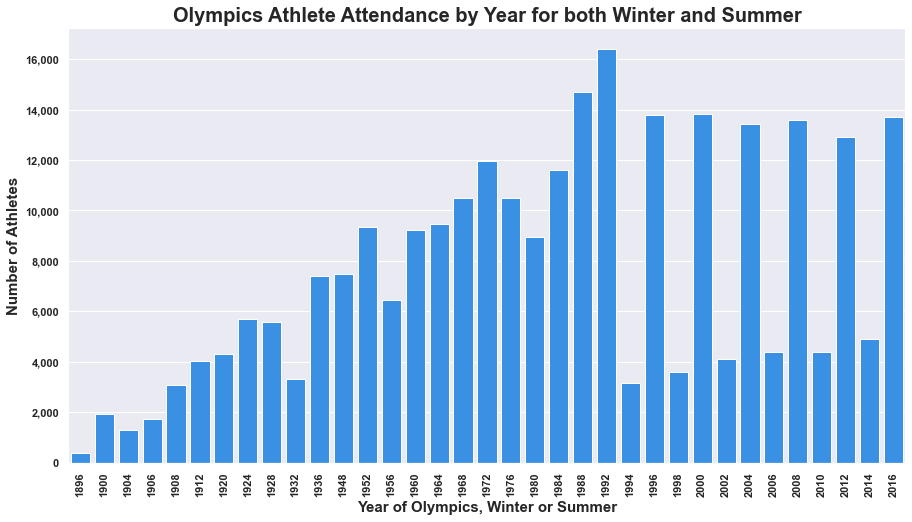

In [116]:
ax=sns.countplot(x='Year', data=olympics, color='dodgerblue')
ax.set_title('Olympics Athlete Attendance by Year for both Winter and Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics, Winter or Summer",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.2 Olympics Athlete Attendance by Year by Winter/Summer***

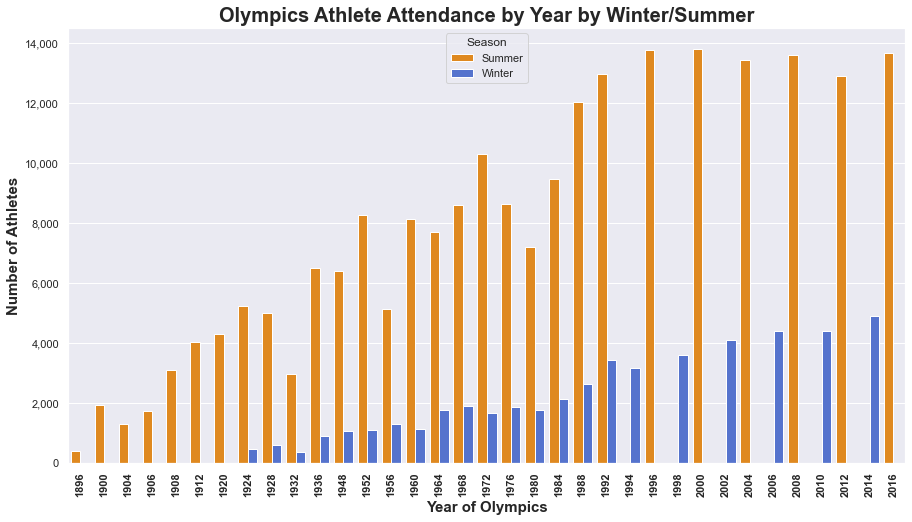

In [117]:
ax=sns.countplot(x='Year', hue = 'Season', data=olympics, palette=['darkorange', 'royalblue'])
ax.set_title('Olympics Athlete Attendance by Year by Winter/Summer', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc]);
#show_values(ax)

***2.3 All Olympics Athlete Attendance by Year, Gender***

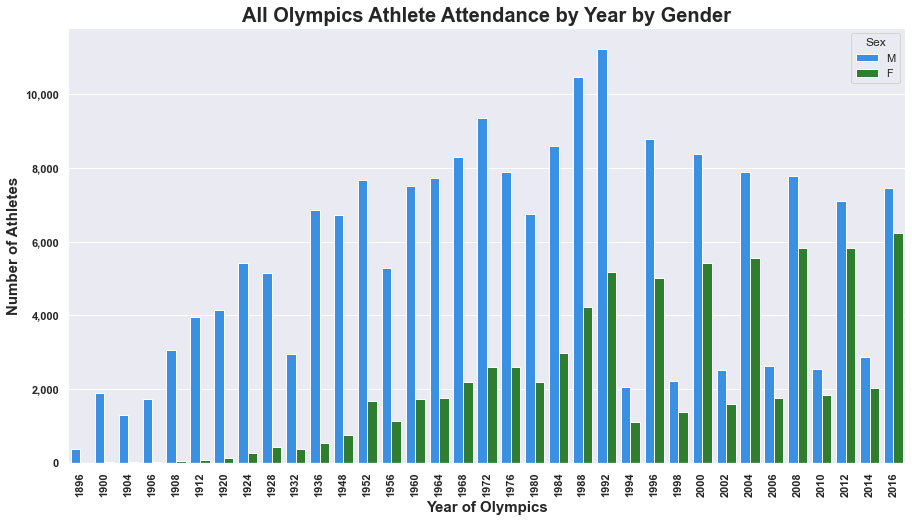

In [118]:
ax=sns.countplot(x='Year', hue = 'Sex', data=olympics, palette=['dodgerblue', 'forestgreen'])
ax.set_title('All Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.4 Summer Olympics Athlete Attendance by Year, Gender***

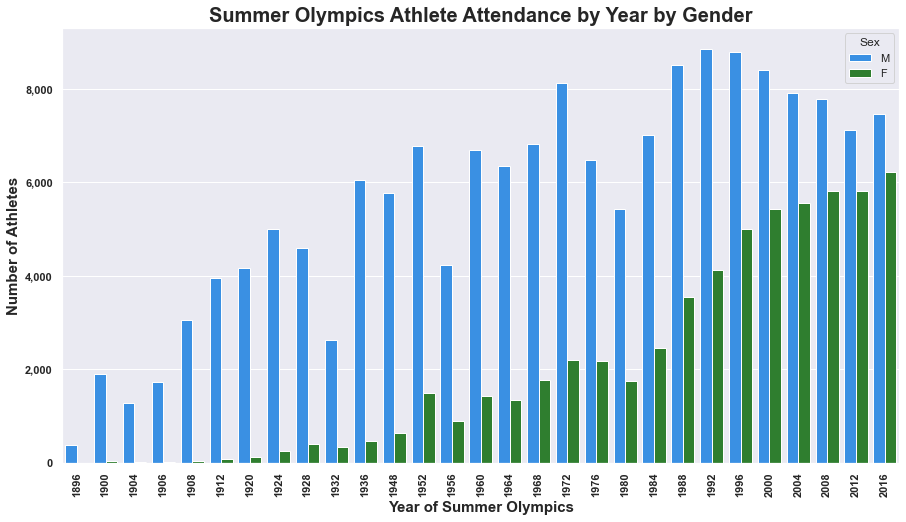

In [119]:
ax=sns.countplot(x='Year', hue = 'Sex', data=summer, palette=['dodgerblue', 'forestgreen'])
ax.set_title('Summer Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Summer Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.5 Winter Olympics Athlete Attendance by Year, Gender***

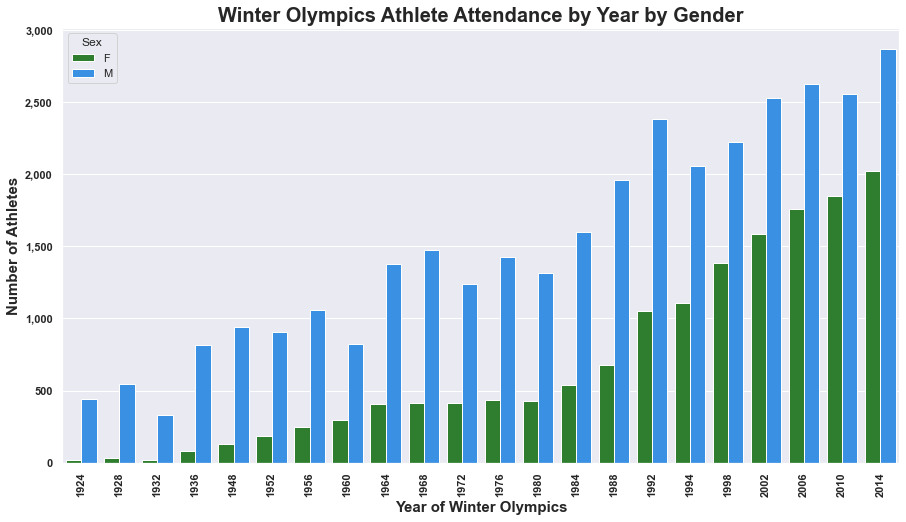

In [120]:
ax=sns.countplot(x='Year', hue = 'Sex', data=winter, palette=['forestgreen', 'dodgerblue'])
ax.set_title('Winter Olympics Athlete Attendance by Year by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Year of Winter Olympics",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.6 All Summer Olympics Sports by Gender***

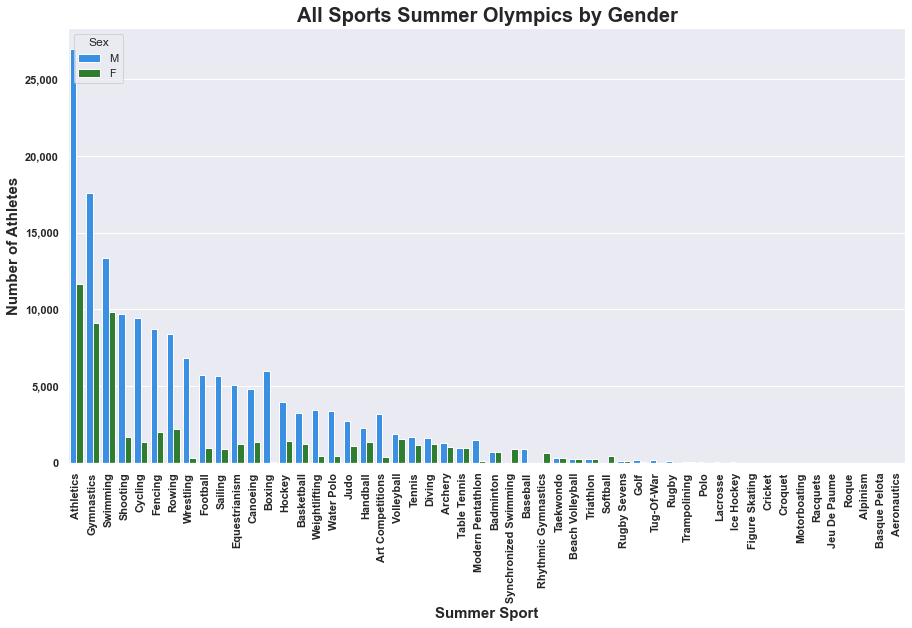

In [121]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer, palette=['dodgerblue', 'forestgreen'],order=summer['Sport'].value_counts().index)
ax.set_title('All Sports Summer Olympics by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

In [122]:
sports = summer['Sport'].value_counts()

In [123]:
sports_3k=sports[sports > 3000]
sports_3k_less=sports[sports <= 3000]

***2.7 Major Sport Summer Olympics by Gender, with at least 3,000 Athletes all time***

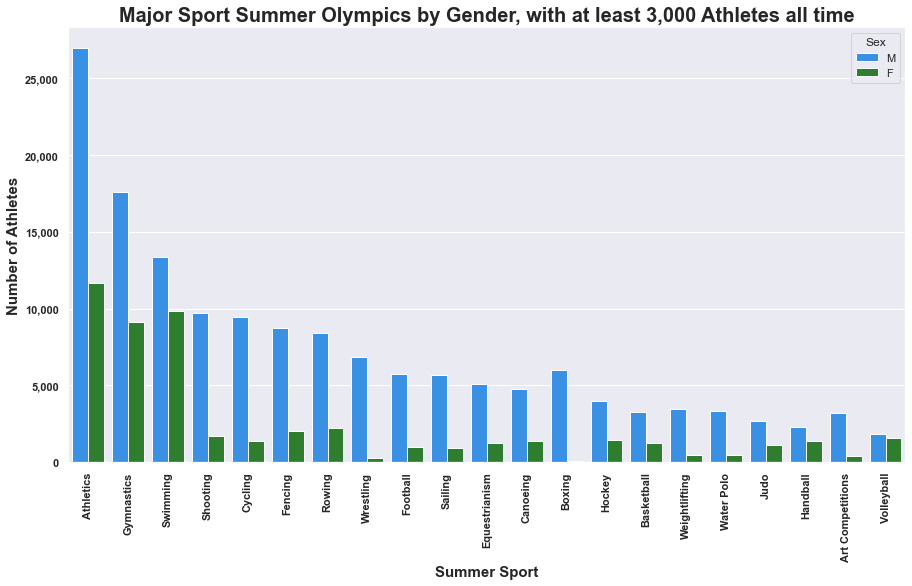

In [124]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer[summer['Sport'].isin(sports_3k.index)], palette=['dodgerblue', 'forestgreen'], order=sports_3k.index)
ax.set_title('Major Sport Summer Olympics by Gender, with at least 3,000 Athletes all time', fontsize = 20,weight='bold')
ax.set_xlabel("Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.8 Minor Sport Summer Olympics by Gender, with less than 3,000 Athletes all time***

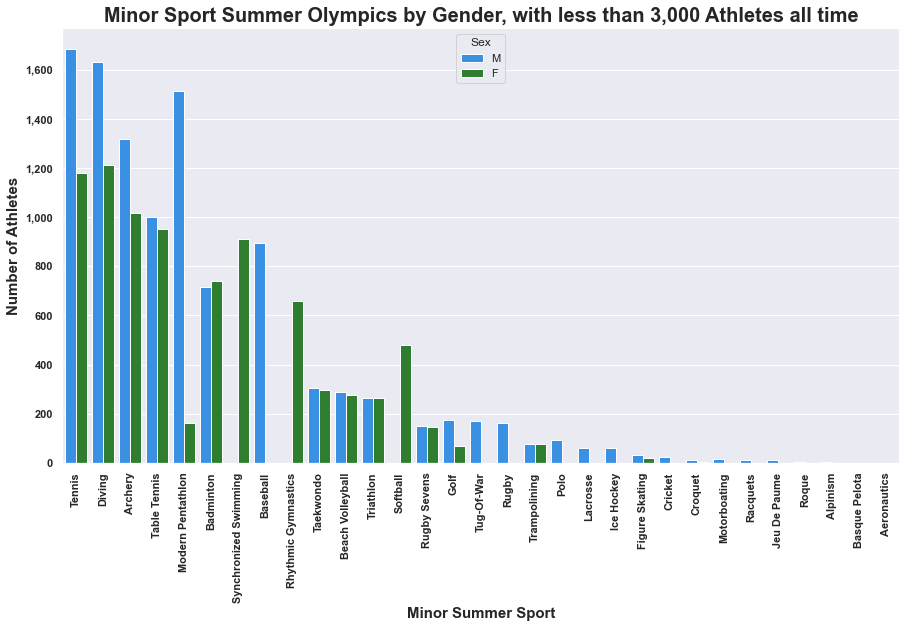

In [125]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=summer[summer['Sport'].isin(sports_3k_less.index)], palette=['dodgerblue', 'forestgreen'], order=sports_3k_less.index)
ax.set_title('Minor Sport Summer Olympics by Gender, with less than 3,000 Athletes all time', fontsize = 20,weight='bold')
ax.set_xlabel("Minor Summer Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

***2.9 All Winter Olympics Sports by Gender***

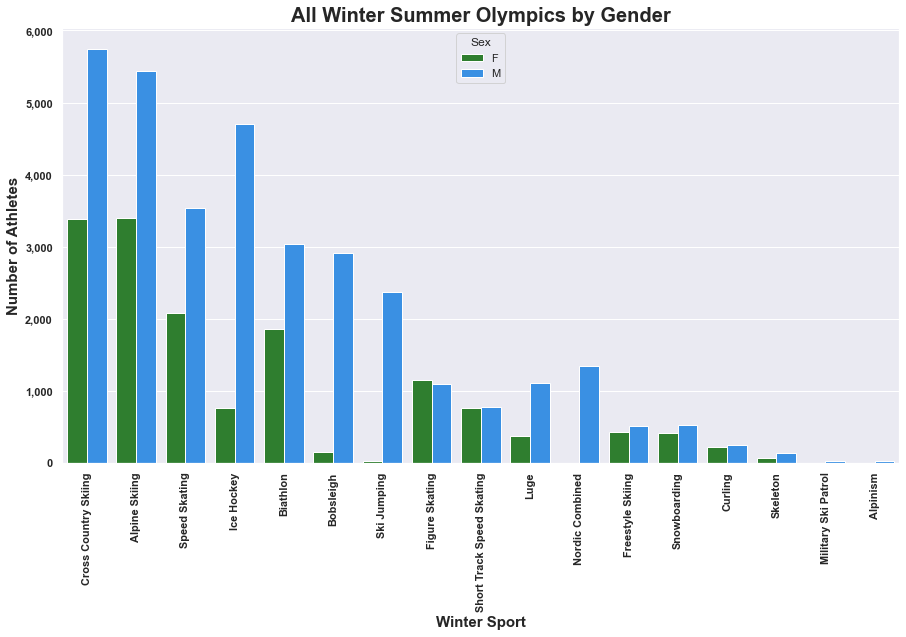

In [126]:
ax=sns.countplot(x='Sport',hue = 'Sex', data=winter, palette=['forestgreen', 'dodgerblue'],order=winter['Sport'].value_counts().index)
ax.set_title('All Winter Summer Olympics by Gender', fontsize = 20,weight='bold')
ax.set_xlabel("Winter Sport",fontsize = 15, weight='bold')
ax.set_ylabel('Number of Athletes',fontsize = 15,weight='bold' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,weight='bold');

ticks_loc = ax.get_yticks().tolist();
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc));
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc],weight='bold');
#show_values(ax)

In [127]:
(pd.crosstab(olympics['Year'], olympics['City'])>0).astype(int).sum()

City
Albertville               1
Amsterdam                 1
Antwerpen                 1
Athina                    3
Atlanta                   1
Barcelona                 1
Beijing                   1
Berlin                    1
Calgary                   1
Chamonix                  1
Cortina d'Ampezzo         1
Garmisch-Partenkirchen    1
Grenoble                  1
Helsinki                  1
Innsbruck                 2
Lake Placid               2
Lillehammer               1
London                    3
Los Angeles               2
Melbourne                 1
Mexico City               1
Montreal                  1
Moskva                    1
Munich                    1
Nagano                    1
Oslo                      1
Paris                     2
Rio de Janeiro            1
Roma                      1
Salt Lake City            1
Sankt Moritz              2
Sapporo                   1
Sarajevo                  1
Seoul                     1
Sochi                     1
Squaw Valley   

In [128]:
olympics = ol
olympics['Country'].value_counts()

USA            18853
Germany        15883
France         12758
UK             12256
Russia         11692
               ...  
Timor-Leste        9
Kosovo             8
Tuvalu             7
South Sudan        3
Unknown            2
Name: Country, Length: 209, dtype: int64

### 1.3.6 Adding New Variables

***Will add EventScore, Gold ->10, Silver ->7, Bronze->5, or NA->1 for qualifying.<br>***
***Will add medal binary, Gold ->1, Silver ->1, Bronze->1, or NA-0 <br>***
***Rename region to Country***

In [129]:
#Gold 10 points
olympics.loc[olympics['Medal']=='Gold', 'EventScore'] = 10
#Silver 7 points
olympics.loc[olympics['Medal']=='Silver', 'EventScore'] = 7.5
#Bronze 4 points
olympics.loc[olympics['Medal']=='Bronze', 'EventScore'] = 5
#Qualification and attendance 1 points
olympics.loc[olympics['Medal'].isnull(), 'EventScore'] = 1
#olympics["region"]=np.where(olympics["region"].isnull(), olympics["notes"],olympics["region"])

In [130]:
olympics['Medal'].value_counts()

Gold      13372
Bronze    13295
Silver    13116
Name: Medal, dtype: int64

In [131]:
olympics['EventScore'].value_counts()

1.0     231354
10.0     13372
5.0      13295
7.5      13116
Name: EventScore, dtype: int64

In [132]:
olympics.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'NOC', 'Country',
       'notes', 'EventScore'],
      dtype='object')

In [133]:
olympics.rename(columns = {'region':'Country'}, inplace = True)

In [134]:
olympics.columns

Index(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'NOC', 'Country',
       'notes', 'EventScore'],
      dtype='object')

In [135]:
# Close the connection to the SQLite Database
conn.close()
print("SQLite Database Connection Closed Sucessfully")

SQLite Database Connection Closed Sucessfully


In [136]:
print(style.GREEN + style.BOLD,"\n",datetime.datetime.now() - startTime, "Time running\n")

 
 0:00:28.108735 Time running

